

## License Plate Detection and Recognition | Shubham Pandey

In [1]:
import os
from lxml import etree
import xml.etree.ElementTree as ET
import glob
import numpy as np
import pandas as pd
import random as rnd
import struct
from tqdm.notebook import tqdm
import easyocr
import matplotlib.pyplot as plt
import imutils
import cv2
from sklearn.model_selection import train_test_split

import tensorflow as tf
from keras.models import Model, load_model
from keras.applications.vgg16 import VGG16
from keras.layers import BatchNormalization, Flatten, Dense
from keras.models import Sequential
import tensorflow_addons as tfa

%matplotlib inline
gpu = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

In [107]:
imfiles = []
lbfiles = []

dr = './car-plate-detection/images'
drlb = './car-plate-detection/annots'

for file in os.listdir(dr):
    imfiles.append(file)
for file in os.listdir(drlb):
    lbfiles.append(file)
    # print(file)
imfiles= sorted(imfiles)
lbfiles = sorted(lbfiles)

In [108]:
print(imfiles[0:10])

['CarLongPlate0.jpg', 'CarLongPlate1.jpg', 'CarLongPlate10.jpg', 'CarLongPlate100.jpg', 'CarLongPlate101.jpg', 'CarLongPlate102.jpg', 'CarLongPlate103.jpg', 'CarLongPlate104.jpg', 'CarLongPlate105.jpg', 'CarLongPlate106.jpg']


In [109]:
IMAGE_SIZE = 224

images = []
dr = './car-plate-detection/images'
for file in  tqdm(imfiles):
    img = cv2.imread(f'{dr}/{file}')
    img = cv2.resize(img, (IMAGE_SIZE,IMAGE_SIZE))
    # img = img.astype('float32')

    # print(img.shape)
    # print(f'{dr}/{file}')
    # print(np.array(img).shape)
    images.append(np.array(img))

print('done')
    


  0%|          | 0/8298 [00:00<?, ?it/s]

done


In [110]:
def resizeannotation(f):
    tree = etree.parse(f)
    width = int(tree.xpath("size").xpath("width")[0].text)
    height = int(tree.xpath("size").xpath("height")[0].text)
    xmin = int(tree.xpath("object/bndbox").xpath("xmin")[0].text)/(width/IMAGE_SIZE )
    ymin = int(tree.xpath("object/bndbox").xpath("ymin")[0].text)/(height/IMAGE_SIZE )
    xmax = int(tree.xpath("object/bndbox").xpath("xmax")[0].text)/(width/IMAGE_SIZE )
    ymax = int(tree.xpath("object/bndbox").xpath("ymax")[0].text)/(height/IMAGE_SIZE )
    return [int(xmax), int(ymax), int(xmin), int(ymin)]

In [111]:
labels = []
dr = './car-plate-detection/annots'
for file in tqdm(lbfiles):
    loc = f'{dr}/{file}'
    # print(loc)
    tree = etree.parse(loc)
    width = int(tree.xpath("size")[0].xpath("width")[0].text)
    height = int(tree.xpath("size")[0].xpath("height")[0].text)
    xmin = int(tree.xpath("object/bndbox")[0].xpath("xmin")[0].text)/(width/IMAGE_SIZE )
    ymin = int(tree.xpath("object/bndbox")[0].xpath("ymin")[0].text)/(height/IMAGE_SIZE )
    xmax = int(tree.xpath("object/bndbox")[0].xpath("xmax")[0].text)/(width/IMAGE_SIZE )
    ymax = int(tree.xpath("object/bndbox")[0].xpath("ymax")[0].text)/(height/IMAGE_SIZE )
    labels.append([int(xmax), int(ymax), int(xmin), int(ymin)])

  0%|          | 0/8298 [00:00<?, ?it/s]

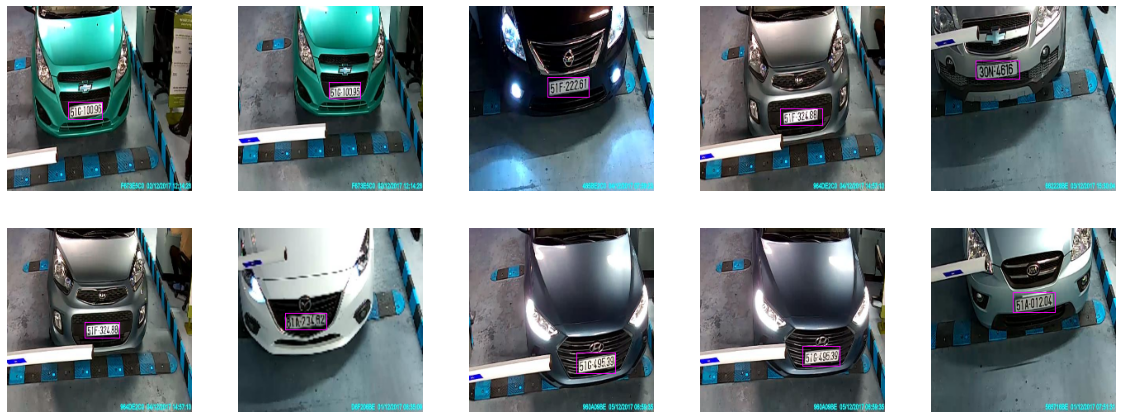

In [112]:
plt.figure(figsize = (20,40))
for i in range(10):
    image = cv2.rectangle(images[i], (labels[i][0], labels[i][1]), (labels[i][2], labels[i][3]), (255, 0, 255))
    plt.subplot(10, 5, i+1)
    plt.axis('off')
    plt.imshow(image)

In [9]:

images = np.asarray(images)
labels = np.asarray(labels)

images = images/255
labels = labels/255


In [10]:
print(images.shape)
print(labels.shape)

In [11]:
print(labels[0])

## Single Shot Detector

In [12]:
X_train, X_test, y_train, y_test = train_test_split(
    images, labels, 
    train_size=0.5, 
    random_state=34)

X_train, X_validation, y_train, y_validation = train_test_split(
    X_train, y_train,                                                    
    test_size=0.1,                                                         
    random_state=34)

In [13]:
# print(X_train.shape)
# print(y_train.shape)

# np.save('X_train_',X_train)
# np.save('y_train_', y_train)


# np.save('X_validation_', X_validation)
# np.save('y_validation_', y_validation)


# np.save('X_test_', X_test)
# np.save('y_test_', y_test)

In [2]:
X_train = np.load('X_train_.npy')
y_train = np.load('y_train_.npy')

X_valid = np.load('X_validation_.npy')
y_valid = np.load('y_validation_.npy')

X_test = np.load('X_test_.npy')
y_test = np.load('y_test_.npy')

# Model (SSD -)

In [15]:
# Create the model
IMAGE_SIZE = 224
model = Sequential()
model.add(VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(Dense(128, activation="relu"))
model.add(Dense(64, activation="relu"))
model.add(Dense(4, activation="sigmoid"))

model.layers[-6].trainable = False

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Functional)           (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 25088)             0         
_________________________________________________________________
dense (Dense)                (None, 128)               3211392   
_________________________________________________________________
dense_1 (Dense)              (None, 128)               16512     
_________________________________________________________________
dense_2 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 260       
Total params: 17,951,108
Trainable params: 3,236,420
Non-trainable params: 14,714,688
____________________________________

In [16]:

print(X_train.shape)
print(y_train.shape)
out= model(X_train[0:5])
[y for y in out]

(3734, 224, 224, 3)
(3734, 4)


[<tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.50900006, 0.51588076, 0.510909  , 0.61640805], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.5196008 , 0.4024289 , 0.59644014, 0.6433359 ], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.5209299 , 0.49968752, 0.5229446 , 0.6525962 ], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.5122676 , 0.40834323, 0.6064383 , 0.67026186], dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([0.56220627, 0.49150866, 0.559974  , 0.6365528 ], dtype=float32)>]

In [17]:
losses = []
val_losses = []
acc = []
val_acc = []


model.layers[-6].trainable = True


lr = 0.000005
optim = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(loss='mean_squared_error', optimizer=optim, metrics=['accuracy'])

In [113]:
model = load_model('model_ssd')

history = model.fit(X_train,y_train, validation_data = (X_valid ,y_valid), epochs=5 , batch_size =8, verbose=1)


Epoch 1/20
467/467 [==============================] - 89s 173ms/step - loss: 4.1717e-04 - accuracy: 0.9518 - val_loss: 9.3184e-04 - val_accuracy: 0.9133
Epoch 2/20
467/467 [==============================] - 78s 168ms/step - loss: 4.2677e-04 - accuracy: 0.9408 - val_loss: 7.1775e-04 - val_accuracy: 0.9566
Epoch 3/20
467/467 [==============================] - 79s 169ms/step - loss: 3.6986e-04 - accuracy: 0.9413 - val_loss: 9.6281e-04 - val_accuracy: 0.9157
Epoch 4/20
467/467 [==============================] - 78s 167ms/step - loss: 3.9873e-04 - accuracy: 0.9467 - val_loss: 5.4113e-04 - val_accuracy: 0.9494
Epoch 5/20
467/467 [==============================] - 76s 164ms/step - loss: 4.0478e-04 - accuracy: 0.9497 - val_loss: 6.3933e-04 - val_accuracy: 0.9542
Epoch 6/20
467/467 [==============================] - 76s 163ms/step - loss: 4.0514e-04 - accuracy: 0.9448 - val_loss: 6.5074e-04 - val_accuracy: 0.9470
Epoch 7/20
467/467 [==============================] - 77s 164ms/step - loss: 3.957

NameError: name 'losses' is not defined

In [ ]:
# model.save('model_ssd')

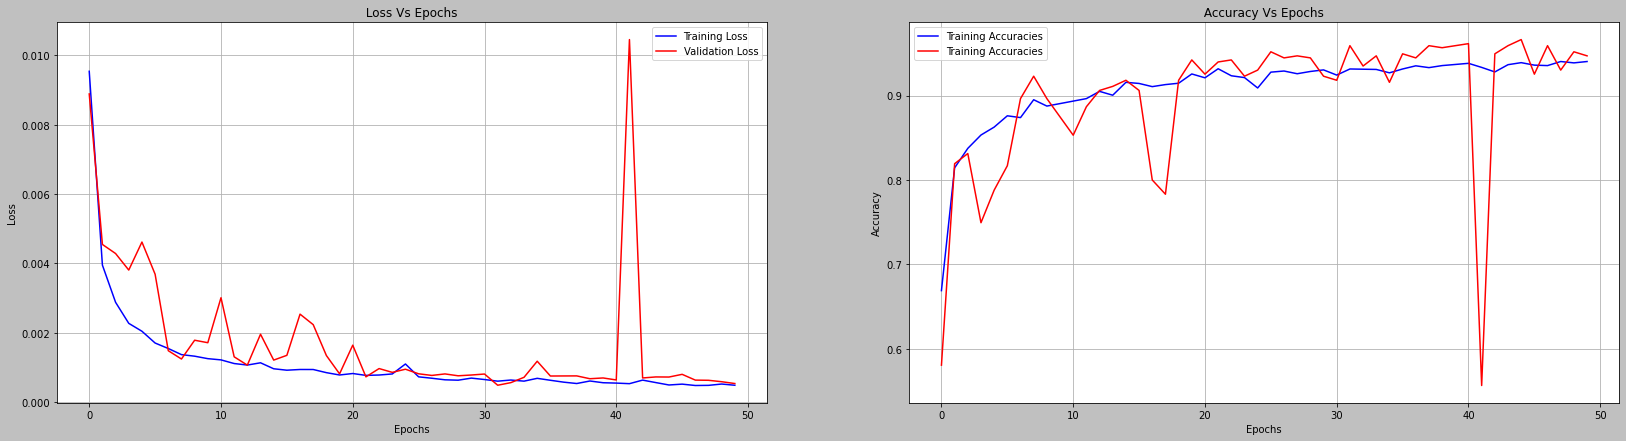

In [ ]:
losses += history.history['loss']
val_losses += history.history['val_loss']
acc += history.history['accuracy']
val_acc += history.history['val_accuracy']


_, ax = plt.subplots(1, 2, figsize=(28, 7), facecolor='silver')
ax[0].set_facecolor('white')
ax[0].plot(losses, "blue", label="Training Loss")
ax[0].plot(val_losses, "red", label="Validation Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title( " Loss Vs Epochs ")
ax[0].grid()
ax[0].legend()

ax[1].set_facecolor('white')
ax[1].plot(acc, "blue", label="Training Accuracies")
ax[1].plot(val_acc, "red", label="Training Accuracies")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title( " Accuracy Vs Epochs ")
ax[1].grid()
ax[1].legend()

In [5]:
model = load_model('model_ssd')

In [7]:
y_cnn = model(X_train[0:20])
print(y_cnn.shape)

(20, 4)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor([0.4642496  0.28002372 0.33363062 0.08407768], shape=(4,), dtype=float32)
tf.Tensor([0.4574835  0.6146134  0.2463167  0.40524143], shape=(4,), dtype=float32)
tf.Tensor([0.50521207 0.62290347 0.34117997 0.37530845], shape=(4,), dtype=float32)
tf.Tensor([0.52829665 0.5376991  0.33741778 0.47653544], shape=(4,), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor([0.50971085 0.47518697 0.30236644 0.39530337], shape=(4,), dtype=float32)
tf.Tensor([0.5723548  0.5973087  0.4765733  0.55122715], shape=(4,), dtype=float32)
tf.Tensor([0.51581204 0.54560363 0.33371988 0.29037407], shape=(4,), dtype=float32)
tf.Tensor([0.50147897 0.47097483 0.29451478 0.39261898], shape=(4,), dtype=float32)
tf.Tensor([0.617804   0.5976848  0.40942815 0.39054835], shape=(4,), dtype=float32)
tf.Tensor([0.7075599  0.6006689  0.18912494 0.15449698], shape=(4,), dtype=float32)
tf.Tensor([0.64332557 0.67844355 0.6302334  0.6278795 ], shape=(4,), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor([0.4182662  0.6224411  0.2816038  0.40318844], shape=(4,), dtype=float32)
tf.Tensor([0.37065807 0.70947814 0.3376     0.5825328 ], shape=(4,), dtype=float32)
tf.Tensor([0.4152319  0.57908803 0.22816354 0.31425393], shape=(4,), dtype=float32)
tf.Tensor([0.6106581  0.6400086  0.42950112 0.55411774], shape=(4,), dtype=float32)
tf.Tensor([0.64271176 0.6820267  0.45843437 0.6194441 ], shape=(4,), dtype=float32)
tf.Tensor([0.47218683 0.6409593  0.3713359  0.595095  ], shape=(4,), dtype=float32)
tf.Tensor([0.4737962  0.56775814 0.297116   0.49055877], shape=(4,), dtype=float32)
tf.Tensor([0.43364096 0.30376998 0.2507107  0.2098713 ], shape=(4,), dtype=float32)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


tf.Tensor([0.69693244 0.67276454 0.45055887 0.52776706], shape=(4,), dtype=float32)


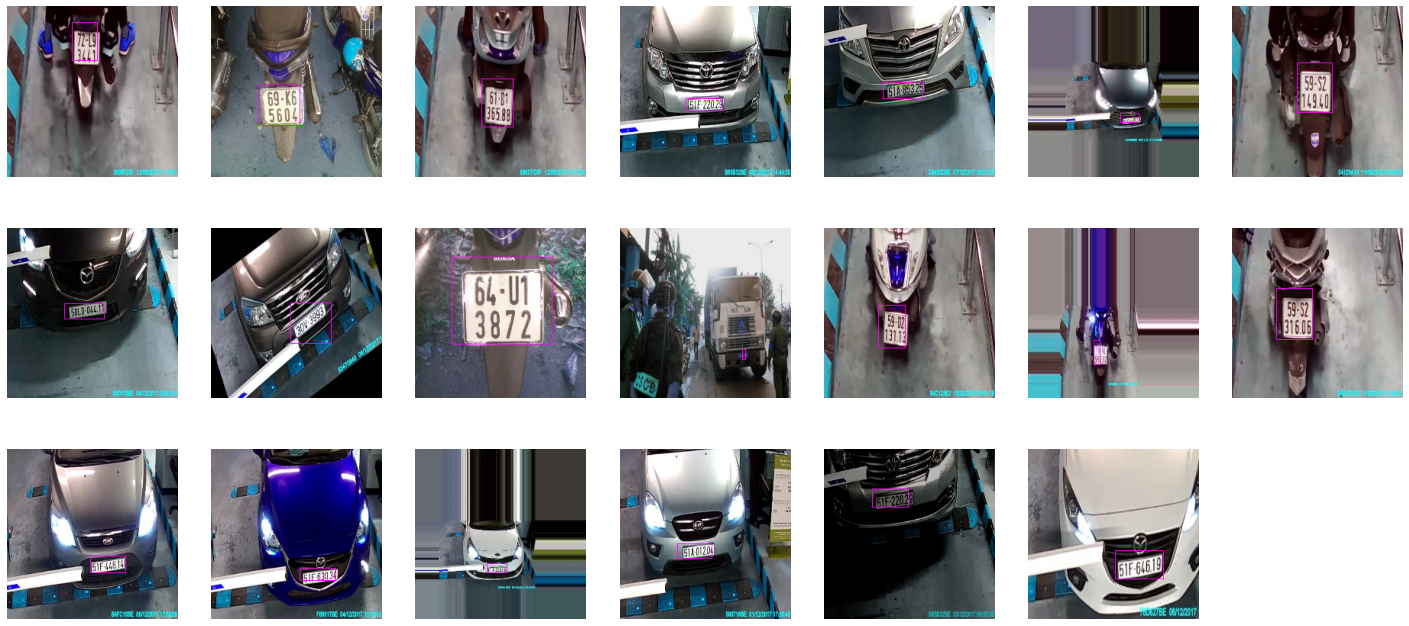

In [10]:
plt.figure(figsize=(25,40))
for i in range(0,20) :
    plt.subplot(10,7,i+1)
    plt.axis('off')
    y = y_cnn[i]*255
    print(y_cnn[i])
    a = int(y[0])
    b = int(y[1])
    c = int(y[2])
    d = int(y[3])
    image = cv2.rectangle(X_train[i],(a,b),(c,d),(255, 0, 255))
    plt.imshow(image)

In [6]:
t_cnn = model(X_test[0:21])
print(t_cnn.shape)



Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

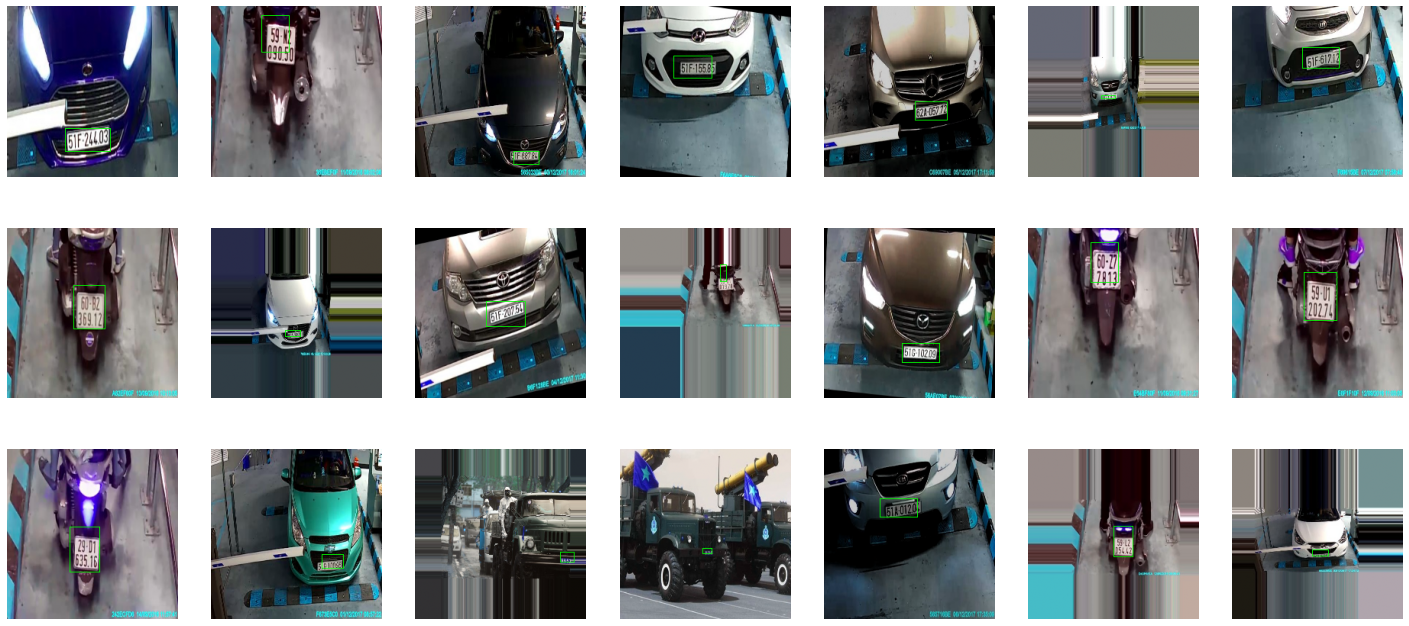

In [5]:
plt.figure(figsize=(25,40))
for i in range(0,21) :
    plt.subplot(10,7,i+1)
    plt.axis('off')
    y = t_cnn[i]*255
    # print(y_cnn[i])
    a = int(y[0])
    b = int(y[1])
    c = int(y[2])
    d = int(y[3])
    image = cv2.rectangle(X_test[i],(a,b),(c,d),(0, 255, 0))
    plt.imshow(image)

# Segmentation technique to extract the text on the license plate

In [40]:
def detect(str_ ='./car-plate-detection/images/xemay281.jpg', i = 0  ):
    img_test_ = cv2.imread(str_)
    # print(img_test_.shape)
    img_test_ = cv2.resize(img_test_, (img_test_.shape[0], img_test_.shape[0]))

    img_test = cv2.resize(img_test_, (224, 224))


    img_test = img_test/255
    img_test = np.reshape(img_test, (1, 224, 224, 3))
    y_test = model.predict(img_test)
    y_test

    y_test = y_test*255
    plt.figure(figsize=(6,6))
    image = cv2.rectangle(img_test[0],(int(y_test[0][0]),int(y_test[0][1])),(int(y_test[0][2]),int(y_test[0][3])),(0, 255, 0))

    plt.imshow(image, interpolation='nearest')
    plt.show()

    x2 = int((y_test[0][0]/224)*img_test_.shape[0])
    y2 = int((y_test[0][1]/224)*img_test_.shape[0])
    x1 = int((y_test[0][2]/224)*img_test_.shape[0])
    y1 = int((y_test[0][3]/224)*img_test_.shape[0])

    # print(x1, x2, y1, y2)

    im_sd = img_test_
    im_sd_ = im_sd[y1:y2,x1:x2,:]


    plt.imshow(im_sd_)

    plt.savefig('./run' + str(i) + '.png')

    return im_sd_


In [41]:
def func_1(plate_image, a):
    t4 = tfa.image.gaussian_filter2d(
        image=plate_image/255 ,
        filter_shape=(20, 20),
        sigma=3,
        # padding='REFLECT',
        constant_values=0,
        name=None
    ).numpy()


    t3 = tf.cast(tf.math.less_equal(
        t4[:, :, 2], a
    ), dtype=tf.float32)


    t4 = tf.stack([t3, t3, t3])
    t5 = tf.transpose(t4, perm=[1, 2, 0])

    out1 = tf.multiply(1-t5, plate_image)

    return out1

def func_2(plate_image, a):
    t4 = tfa.image.gaussian_filter2d(
        image=plate_image/255 ,
        filter_shape=(1, 1),
        sigma=2,
        # padding='REFLECT',
        constant_values=0,
        name=None
    ).numpy()


    t3 = tf.cast(tf.math.less_equal(
        t4[:, :, 2], a
    ), dtype=tf.float32)


    t4 = tf.stack([t3, t3, t3])
    t5 = tf.transpose(t4, perm=[1, 2, 0])

    out2 = tf.multiply(1-t5, plate_image)

    return out2



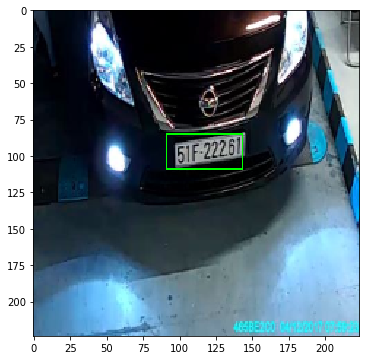

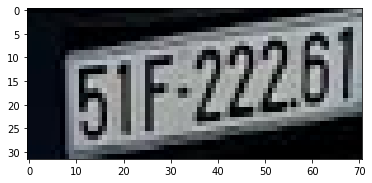

In [42]:
plate0 = detect('./car-plate-detection/images/CarLongPlate10.jpg',1 )

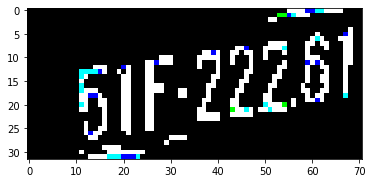

In [68]:
out1 = func_1(plate0, .32)
out2 = func_2(plate0, 0.35)
final = out1 - out2
plt.imshow(final)
plt.savefig('run1.png')

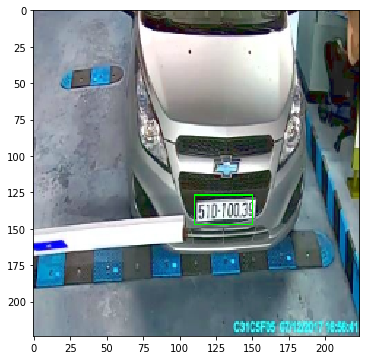

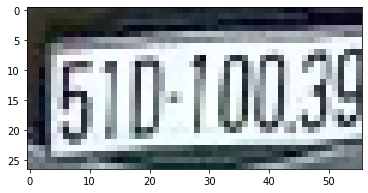

In [69]:
plate2 = detect('./car-plate-detection/images/CarLongPlateGen1726.jpg',2)

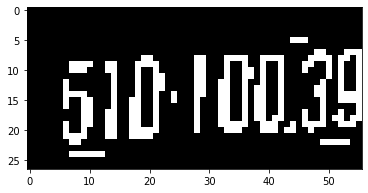

In [104]:
out1 = func_1(plate2, .623)
out2 = func_2(plate2, 0.77)
final = out1 - out2
plt.imshow(final)
plt.savefig('run2.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(557, 857, 3)


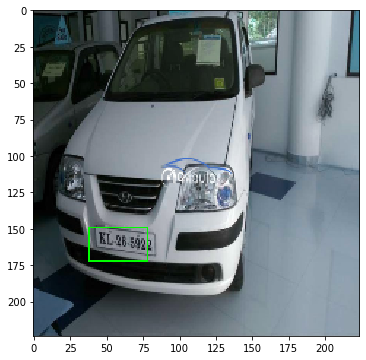

95 195 371 429


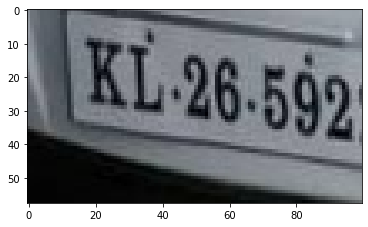

In [510]:
plate_5 = detect('Hyundai_Santro_Xing_-098-8909.jpg', 5)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


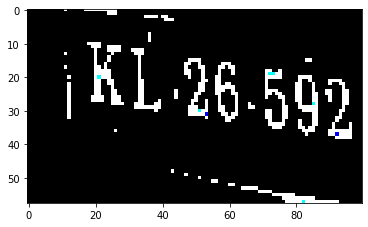

In [553]:
out1 = func_1(plate_5, .25)
out2 = func_2(plate_5, 0.24)
final = out1 - out2
plt.imshow(final)
plt.savefig('run_5.png')

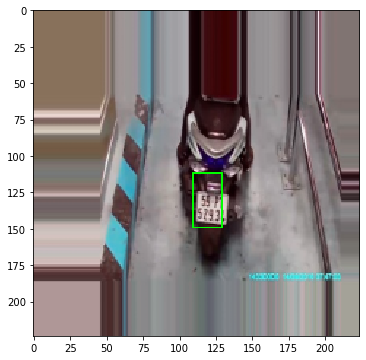

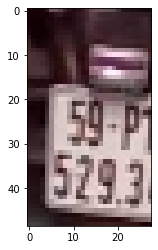

In [105]:
plate_6  = detect('./car-plate-detection/images/xemay2464.jpg', 6)

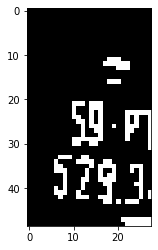

In [125]:
out1 = func_1(plate_6, .43)
out2 = func_2(plate_6, 0.47)
final = out1 - out2
plt.imshow(final)
plt.savefig('run_6.png')

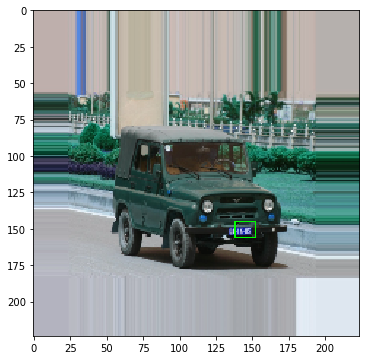

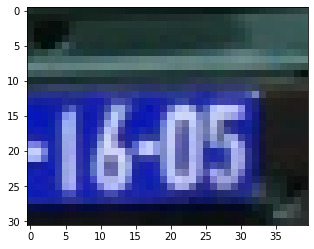

In [127]:
plate_7 = detect('./car-plate-detection/images/boderquandoi13.jpg', 7)

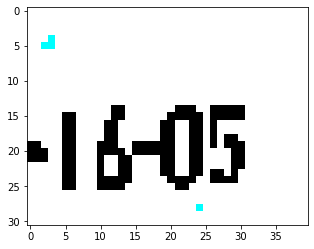

In [148]:
out1 = func_1(plate_7, .1)
out2 = func_2(plate_7, 0.78)
final = out1 - out2
plt.imshow(final)
plt.savefig('run7.png')

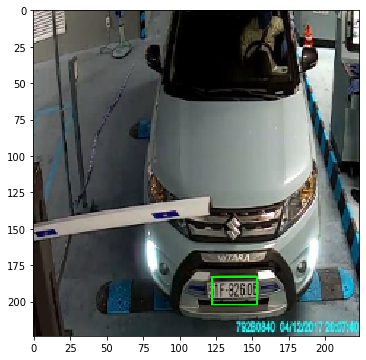

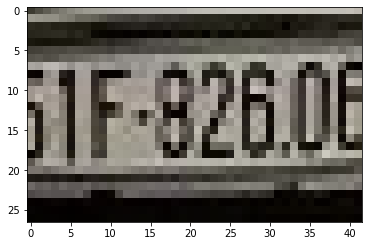

In [149]:
plate_9 = detect('./car-plate-detection/images/CarLongPlate34.jpg',9)

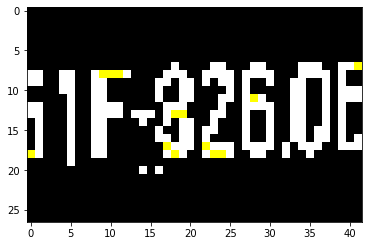

In [186]:
out1 = func_1(plate_9, .35)
out2 = func_2(plate_9, 0.42)
final = out1 - out2
plt.imshow(final)
plt.savefig('run9.png')

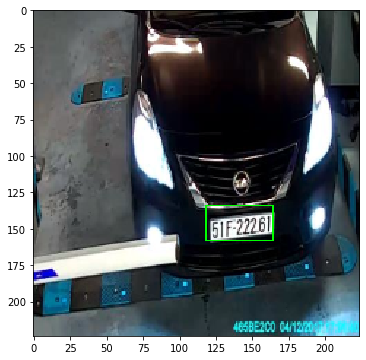

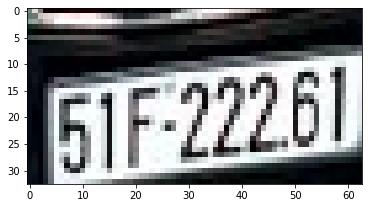

In [187]:
plate_10 = detect('./car-plate-detection/images/CarLongPlate94.jpg',10 )

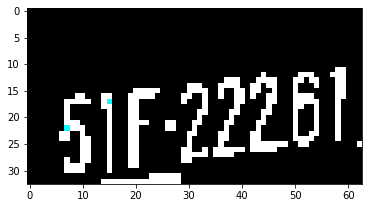

In [205]:
out1 = func_1(plate_10, 0.56)
out2 = func_2(plate_10, 0.65)
final = out1 - out2
plt.imshow(final)
plt.savefig('run10.png')

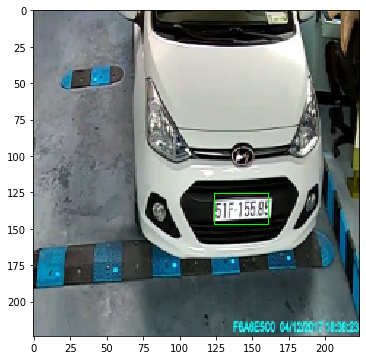

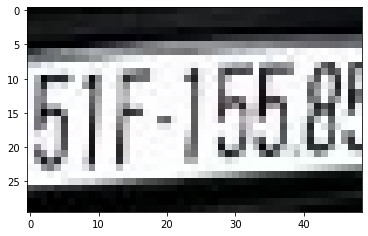

In [207]:
plate_11 = detect('./car-plate-detection/images/CarLongPlate93.jpg',11 )

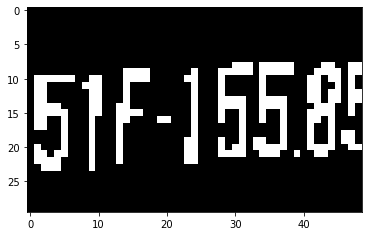

In [218]:
out1 = func_1(plate_11, .6)
out2 = func_2(plate_11, 0.76)
final = out1 - out2
plt.imshow(final)
plt.savefig('run11.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(303, 472, 3)


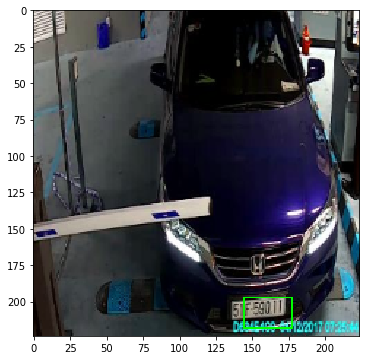

194 240 267 295


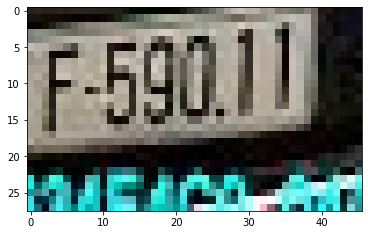

In [442]:
plate_10= detect('./car-plate-detection/images/CarLongPlate17.jpg',1 )


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


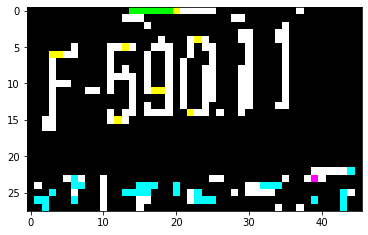

In [509]:
out1 = func_1(plate_10, .37)
out2 = func_2(plate_10, 0.39)
final = out1 - out2
plt.imshow(final)
plt.savefig('run_10.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(303, 472, 3)


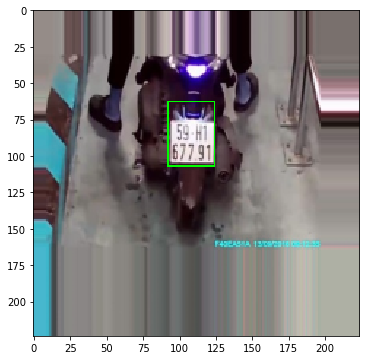

125 168 86 145


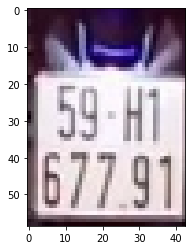

In [555]:
plate_11= detect('./car-plate-detection/images/xemay2370.jpg',1 )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


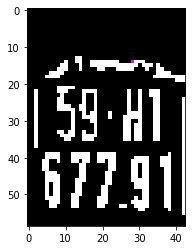

In [610]:
out1 = func_1(plate_11, .615)
out2 = func_2(plate_11, 0.80)
final = out1 - out2
plt.imshow(final)
plt.savefig('run_11.png')

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


(303, 472, 3)


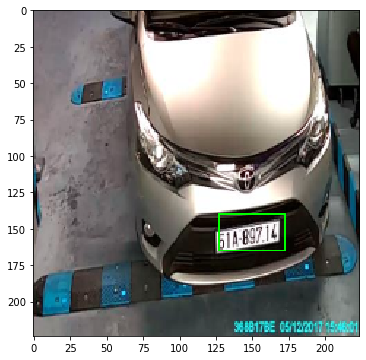

172 233 189 223


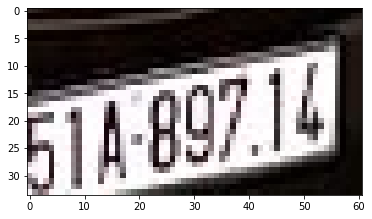

In [612]:
plate_12= detect('./car-plate-detection/images/CarLongPlate272.jpg',1 )

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


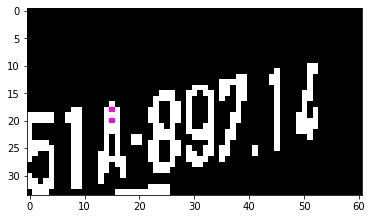

In [650]:
out1 = func_1(plate_12, .60)
out2 = func_2(plate_12, 0.75)
final = out1 - out2
plt.imshow(final)
plt.savefig('run_12.png')

(734, 1090, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


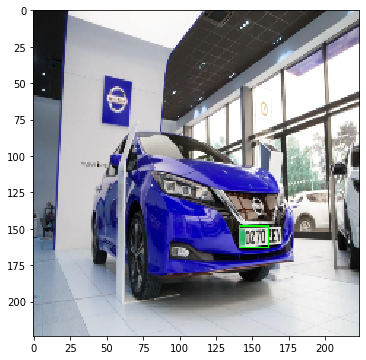

462 530 486 535


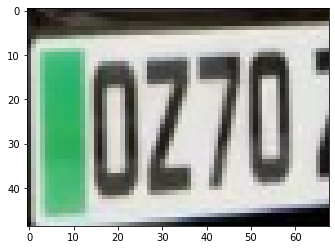

In [659]:
plate_14= detect('./Cars.jpg',14 )

# OCR to recognize the text on the license plate

In [51]:
import imutils
import easyocr

In [50]:
def ocr_text(str_):
  img = cv2.imread(str_)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  # plt.imshow(cv2.cvtColor(gray, cv2.COLOR_BGR2RGB))
  # plt.show()
  reader = easyocr.Reader(['en'])
  result = reader.readtext(gray)
  result
  # print(result)
  text = str.upper(result[0][1])
  font = cv2.FONT_HERSHEY_SIMPLEX
  res = cv2.putText(img, text=text, org=(0, 0+30), fontFace=font, fontScale=1, color=(0,0,255), thickness=4, lineType=cv2.LINE_AA)
  plt.imshow(cv2.cvtColor(res, cv2.COLOR_BGR2RGB))
  plt.show()

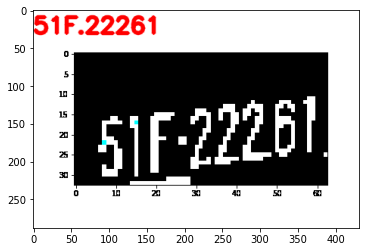

In [ ]:
ocr_text('./run_1.png')

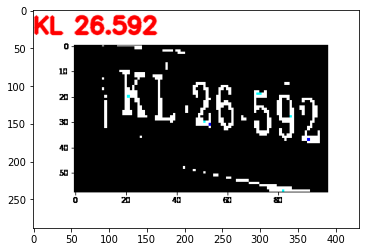

In [ ]:
ocr_text('./run_5.png')

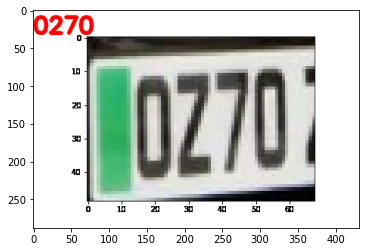

In [53]:
ocr_text('./run14.png')

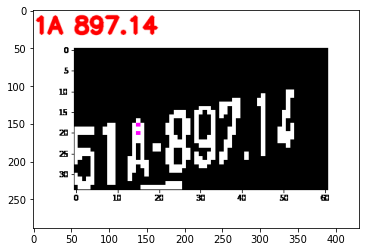

In [ ]:
ocr_text('./run_12.png')

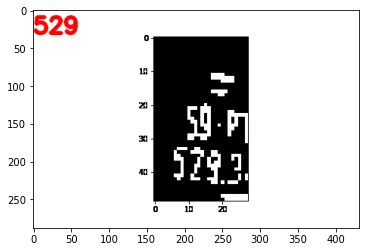

In [ ]:
ocr_text('./run_9.png')

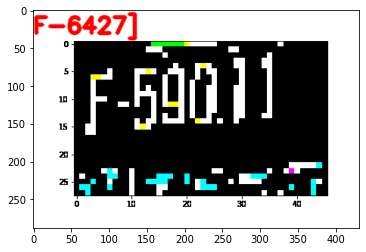

In [ ]:
ocr_text('./run_10.png')

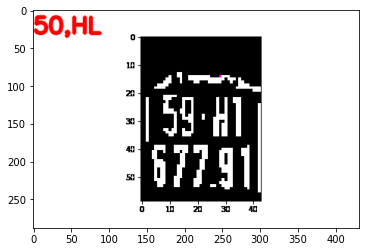

In [ ]:
ocr_text('./run_11.png')

# Model Optimisation with tflite (minimize the latency of the solution)

In [6]:
import pathlib
saved_model_dir = './model_ssd copy'
model = load_model('model_ssd')

In [7]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\SHUBHA~1\AppData\Local\Temp\tmpvyb1fyc2\assets


In [8]:
# enable the default optimizations flag to quantize all fixed parameters (such as weights):

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\SHUBHA~1\AppData\Local\Temp\tmpe7w4l2wf\assets


INFO:tensorflow:Assets written to: C:\Users\SHUBHA~1\AppData\Local\Temp\tmpe7w4l2wf\assets


In [13]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(X_train[0:8].astype('float32')).batch(1).take(8):
    yield [input_value]

converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
# Ensure that if any ops can't be quantized, the converter throws an error
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# Set the input and output tensors to uint8 (APIs added in r2.3)
converter.inference_input_type = tf.uint8
converter.inference_output_type = tf.uint8

tflite_model_quant = converter.convert()

INFO:tensorflow:Assets written to: C:\Users\SHUBHA~1\AppData\Local\Temp\tmpovt254be\assets


INFO:tensorflow:Assets written to: C:\Users\SHUBHA~1\AppData\Local\Temp\tmpovt254be\assets


In [14]:
interpreter = tf.lite.Interpreter(model_content=tflite_model_quant)
input_type = interpreter.get_input_details()[0]['dtype']
print('input: ', input_type)
output_type = interpreter.get_output_details()[0]['dtype']
print('output: ', output_type)

input:  <class 'numpy.uint8'>
output:  <class 'numpy.uint8'>


In [15]:
tflite_models_dir = pathlib.Path("/tmp/ssd_tflite_models/")
tflite_models_dir.mkdir(exist_ok=True, parents=True)

# Save the unquantized/float model:
tflite_model_file = tflite_models_dir/"ssd_model.tflite"
tflite_model_file.write_bytes(tflite_model)
# Save the quantized model:
tflite_model_quant_file = tflite_models_dir/"ssd_model_quant.tflite"
tflite_model_quant_file.write_bytes(tflite_model_quant)

18079472

In [21]:
# Helper function to run inference on a TFLite model
def run_tflite_model(tflite_file, test_image_indices):
  global test_images

  # Initialize the interpreter
  interpreter = tf.lite.Interpreter(model_path=str(tflite_file))
  interpreter.allocate_tensors()

  input_details = interpreter.get_input_details()[0]
  output_details = interpreter.get_output_details()[0]

  predictions = np.zeros((len(test_image_indices),), dtype=int)
  for i, test_image_index in enumerate(test_image_indices):
    test_image = X_test[test_image_index]
    test_label = y_test[test_image_index]

    # Check if the input type is quantized, then rescale input data to uint8
    if input_details['dtype'] == np.uint8:
      input_scale, input_zero_point = input_details["quantization"]
      test_image = test_image / input_scale + input_zero_point

    test_image = np.expand_dims(test_image, axis=0).astype(input_details["dtype"])
    interpreter.set_tensor(input_details["index"], test_image)
    interpreter.invoke()
    output = interpreter.get_tensor(output_details["index"])[0]

    predictions= output

  return predictions

In [28]:
## Helper function to test the models on one image
def test_model(tflite_file, test_image_index, model_type):

    y = run_tflite_model(tflite_file, [test_image_index])
    y = y*255
    print(y)

    a = int(y[0])
    b = int(y[1])
    c = int(y[2])
    d = int(y[3])
    image = cv2.rectangle(X_test[test_image_index],(a,b),(c,d),(255, 0, 255))
    plt.imshow(image)

#    plt.imshow(X_test[test_image_index])
#   template = model_type + " Model \n True:{true}, Predicted:{predict}"
#   _ = plt.title(template.format(true= str(y_testtest_image_index]), predict=str(predictions[0])))
#   plt.grid(False)

[130.87021 188.97444  84.35608 150.96973]


[180.0449  169.19258  96.77161 125.25971]


[215.40384 150.7345  196.65886 134.32396]


[132.00966 152.92934 100.19085 133.03828]


[118.59442  101.56822   78.662964  66.90917 ]


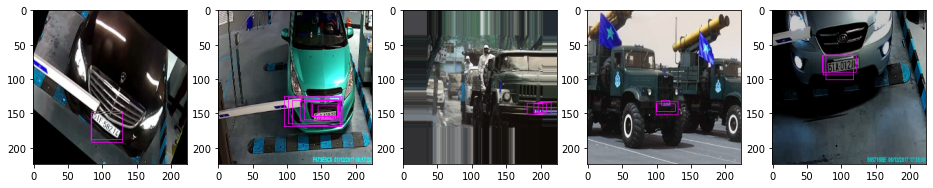

In [38]:
# Change this to test a different image
plt.figure(figsize=(16,5))

plt.subplot(1,5,1)

test_image_index = 21
test_model(tflite_model_file, test_image_index, model_type="Float")

plt.subplot(1,5,2)
test_image_index = 15
test_model(tflite_model_file, test_image_index, model_type="Float")

plt.subplot(1,5,3)
test_image_index = 16
test_model(tflite_model_file, test_image_index, model_type="Float")

plt.subplot(1,5,4)
test_image_index = 17
test_model(tflite_model_file, test_image_index, model_type="Float")

plt.subplot(1,5,5)
test_image_index = 18
test_model(tflite_model_file, test_image_index, model_type="Float")

# YOLO implementation

In [30]:
X_train, X_test, y_train, y_test = train_test_split(
    images[0:1000], labels[0:1000], 
    train_size=0.7, 
    random_state=34)

X_train, X_validation, y_train, y_validation = train_test_split(
    X_train, y_train,                                                    
    test_size=0.1,                                                         
    random_state=34)

In [31]:
# print(X_train.shape)
# print(y_train.shape)

# np.save('X_train',X_train)
# np.save('y_train', y_train)


# np.save('X_validation', X_validation)
# np.save('y_validation', y_validation)


# np.save('X_test', X_test)
# np.save('y_test', y_test)

(630, 416, 416, 3)
(630, 4)


In [2]:
X_train = np.load('X_train.npy')
y_train = np.load('y_train.npy')

X_valid = np.load('X_validation.npy')
y_valid = np.load('y_validation.npy')

X_test = np.load('X_test.npy')
y_test = np.load('y_test.npy')

# YOLO V3 Model 

In [ ]:
from keras.layers import ZeroPadding2D, Conv2D, LeakyReLU, Input, add, UpSampling2D, concatenate

In [4]:

 # Creating the Model
def _conv_block(inp, convs, skip=True):
	x = inp
	count = 0
	for conv in convs:
		if count == (len(convs) - 2) and skip:
			skip_connection = x
		count += 1
		if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
		x = Conv2D(conv['filter'],
				   conv['kernel'],
				   strides=conv['stride'],
				   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
				   name='conv_' + str(conv['layer_idx']),
				   use_bias=False if conv['bnorm'] else True)(x)
		if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
		if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
	return add([skip_connection, x]) if skip else x
 
def make_yolov3_model():
	input_image = Input(shape=(416, 416, 3))
	# Layer  0 => 4
	x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
								  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
								  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
								  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
	# Layer  5 => 8
	x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
						{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
	# Layer  9 => 11
	x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
	# Layer 12 => 15
	x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
						{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
						{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
	# Layer 16 => 36
	for i in range(7):
		x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
							{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
	skip_36 = x
	# Layer 37 => 40
	x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
	# Layer 41 => 61
	for i in range(7):
		x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
							{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
	skip_61 = x
	# Layer 62 => 65
	x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
	# Layer 66 => 74
	for i in range(3):
		x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
							{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
	# Layer 75 => 79
	x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
	# Layer 80 => 82
	yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
							  {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
	# Layer 83 => 86
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_61])
	# Layer 87 => 91
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
	# Layer 92 => 94
	yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
							  {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
	# Layer 95 => 98
	x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_36])
	# Layer 99 => 106
	yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
							   {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
	model = Model(input_image,  yolo_82)
	return model
 
class WeightReader:
	def __init__(self, weight_file):
		with open(weight_file, 'rb') as w_f:
			major,	= struct.unpack('i', w_f.read(4))
			minor,	= struct.unpack('i', w_f.read(4))
			revision, = struct.unpack('i', w_f.read(4))
			if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
				w_f.read(8)
			else:
				w_f.read(4)
			transpose = (major > 1000) or (minor > 1000)
			binary = w_f.read()
		self.offset = 0
		self.all_weights = np.frombuffer(binary, dtype='float32')
 
	def read_bytes(self, size):
		self.offset = self.offset + size
		return self.all_weights[self.offset-size:self.offset]
 
	def load_weights(self, model):
		for i in range(82):
			try:
				conv_layer = model.get_layer('conv_' + str(i))
				print("loading weights of convolution #" + str(i))
				if i not in [81, 93, 105]:
					norm_layer = model.get_layer('bnorm_' + str(i))
					size = np.prod(norm_layer.get_weights()[0].shape)
					beta  = self.read_bytes(size) # bias
					gamma = self.read_bytes(size) # scale
					mean  = self.read_bytes(size) # mean
					var   = self.read_bytes(size) # variance
					weights = norm_layer.set_weights([gamma, beta, mean, var])
				if len(conv_layer.get_weights()) > 1:
					bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel, bias])
				else:
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel])
			except ValueError:
				print("no convolution #" + str(i))
 
	def reset(self):
		self.offset = 0
 
# define the model
model = make_yolov3_model()
# load the model weights
weight_reader = WeightReader('yolov3.weights')
# set the model weights into the model
weight_reader.load_weights(model)
# save the model to file
model.save('model.h5')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

E:\Users\Shubham Kumar Pandey\Anaconda3\envs\TF_2.6_CUDA_11.2\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [5]:
model = load_model('model.h5')

for layer in model.layers:
    layer.trainable = False



In [6]:
yolo = Sequential()
yolo.add(model)
yolo.add(Flatten())
yolo.add(Dense(128, activation="relu", name = 'fine'))
yolo.add(BatchNormalization())
yolo.add(Dense(128, activation="relu"))
yolo.add(BatchNormalization())
yolo.add(Dense(64, activation="relu"))
yolo.add(Dense(4, activation="sigmoid"))
    

In [7]:
print(X_train.shape)
print(y_train.shape)
out= yolo(X_train[0:5])
[y for y in out]

In [8]:

lr = 5e-5

optim = tf.keras.optimizers.Adam(learning_rate=lr)
loss = tf.keras.losses.MeanSquaredError()
yolo.compile(loss='mean_squared_error', optimizer=optim, metrics=['accuracy'])

In [9]:
losses = []
val_losses = []

acc = []
val_acc = []

step = 0
epochs = 5
epoch = 0

In [10]:
yolo.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Functional)           (None, 13, 13, 255)       56629087  
_________________________________________________________________
flatten (Flatten)            (None, 43095)             0         
_________________________________________________________________
fine (Dense)                 (None, 128)               5516288   
_________________________________________________________________
batch_normalization (BatchNo (None, 128)               512       
_________________________________________________________________
dense (Dense)                (None, 128)               16512     
_________________________________________________________________
batch_normalization_1 (Batch (None, 128)               512       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                8

In [3]:
yolo = load_model('model_yolo_82')


for layer in yolo.layers:
    layer.trainable = False

lr = 5e-5

optim = tf.keras.optimizers.Adam(learning_rate=lr)
loss = tf.keras.losses.MeanSquaredError()
yolo.compile(loss='mean_squared_error', optimizer=optim, metrics=['accuracy'])

history = yolo.fit(X_train,y_train, validation_data = (X_valid,y_valid), epochs=50, batch_size = 4, verbose=1)

Epoch 1/50
315/315 [==============================] - 69s 176ms/step - loss: 0.1095 - accuracy: 0.3889 - val_loss: 0.1346 - val_accuracy: 0.1714
Epoch 2/50
315/315 [==============================] - 55s 173ms/step - loss: 0.0941 - accuracy: 0.3730 - val_loss: 0.0899 - val_accuracy: 0.3571
Epoch 3/50
315/315 [==============================] - 54s 173ms/step - loss: 0.0698 - accuracy: 0.3714 - val_loss: 0.0767 - val_accuracy: 0.4571
Epoch 4/50
315/315 [==============================] - 55s 173ms/step - loss: 0.0719 - accuracy: 0.3810 - val_loss: 0.1329 - val_accuracy: 0.4286
Epoch 5/50
315/315 [==============================] - 55s 173ms/step - loss: 0.0733 - accuracy: 0.4476 - val_loss: 0.0773 - val_accuracy: 0.2143
Epoch 6/50
315/315 [==============================] - 55s 173ms/step - loss: 0.0589 - accuracy: 0.4635 - val_loss: 0.0807 - val_accuracy: 0.3857
Epoch 7/50
315/315 [==============================] - 55s 173ms/step - loss: 0.0614 - accuracy: 0.4492 - val_loss: 0.0598 - val_ac

In [4]:
# yolo.save('model_yolo_82')

INFO:tensorflow:Assets written to: model_yolo_82\assets


E:\Users\Shubham Kumar Pandey\Anaconda3\envs\TF_2.6_CUDA_11.2\lib\site-packages\keras\utils\generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


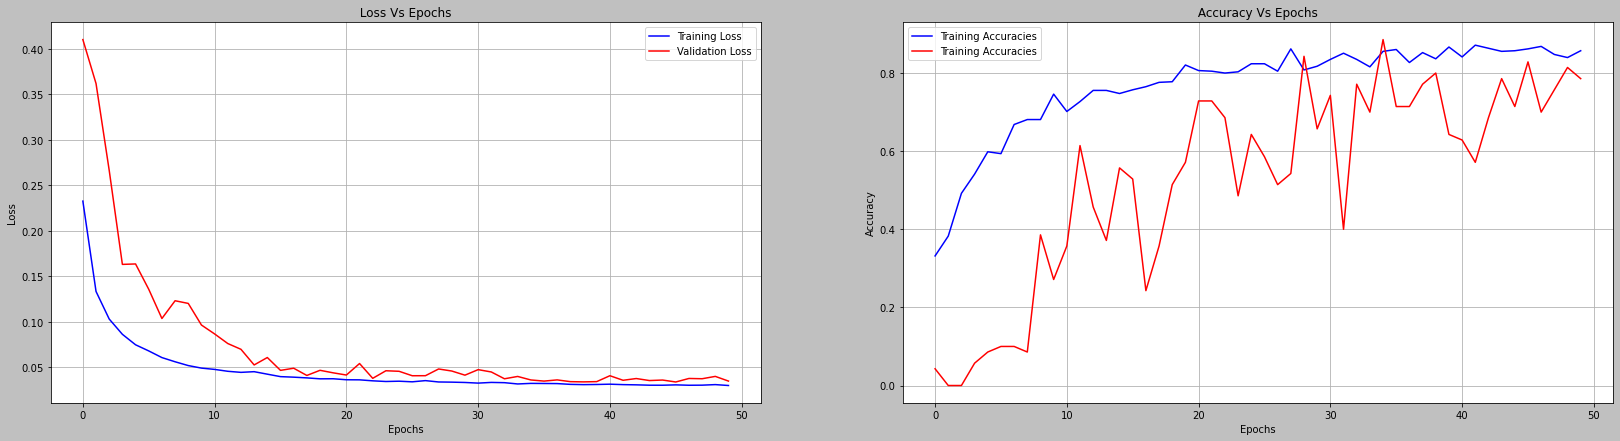

In [ ]:
losses += history.history['loss']
val_losses += history.history['val_loss']

acc= history.history['accuracy']
val_acc = history.history['val_accuracy']

np.save('losses_yolo',losses)
np.save('val_losses_yolo',val_losses)
np.save('acc_yolo',acc)
np.save('val_acc_yolo',val_acc)

_, ax = plt.subplots(1, 2, figsize=(28, 7), facecolor='silver')
ax[0].set_facecolor('white')
ax[0].plot(losses[0:50], "blue", label="Training Loss")
ax[0].plot(val_losses[0:50], "red", label="Validation Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].set_title( " Loss Vs Epochs ")
ax[0].grid()
ax[0].legend()

ax[1].set_facecolor('white')
ax[1].plot(acc[0:50], "blue", label="Training Accuracies")
ax[1].plot(val_acc[0:50], "red", label="Training Accuracies")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].set_title( " Accuracy Vs Epochs ")
ax[1].grid()
ax[1].legend()

In [ ]:
yolo = load_model('model_yolo_82')

img_test = cv2.imread('./car-plate-detection/images/boderngoaigiao4.jpg')
img_test = cv2.resize(img_test, (416, 416))


img_test = img_test/255
img_test = np.reshape(img_test, (1, 416, 416, 3))
y_test = yolo.predict(img_test)
y_test
print(y_test.shape)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


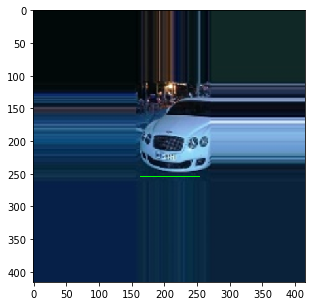

In [6]:
y_test = y_test*255
plt.figure(figsize = (5,5))
image = cv2.rectangle(img_test[0],(int(y_test[0][0]),int(y_test[0][1])),(int(y_test[0][2]),int(y_test[0][3])),(0, 255, 0))
plt.imshow(image, interpolation='nearest')
plt.show()